In [191]:
# tools for handling files
import sys
import os
# pandas/numpy for handling data
import pandas as pd
import numpy as np
# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns
# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval
# for grabbing individual cells
import more_itertools
# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization
import xgboost
import shap
import imgkit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

# setting darkgrid style for seaborn figures
# sns.set(font='helvetica')
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning (ML) - predicting mean telomere length post-therapy (4 C) using pre-therapy individual telos

## Loading/merging data for ML

In [192]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [193]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, all_patients_df=all_patients_df)
print(telo_data.shape)
telo_data_head_15 = telo_data.head(15)

(128800, 4)


In [194]:
path=f'../graphs/paper figures/supp figs/view of precleaned individual telomere length dataframe.png'
trp.df_to_png(df=telo_data_head_15, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Train/test split 

In [195]:
telo_test = telo_data.copy()
train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id', 'timepoint']])

## Initializing cleaning/model pipelines

In [196]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [197]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=1)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning data with pipeline

In [198]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

In [199]:
train_clean_head_15 = train_clean[['timepoint_2 irrad @ 4 Gy', 'individual telomeres', '4 C telo means']].copy().head(15)
path=f'../graphs/paper figures/supp figs/view of cleaned individual telomere length dataframe.png'
trp.df_to_png(df=train_clean_head_15, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Random GridSearch for pipeline/model params

In [121]:
# #XGBoost params for random grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Bayesian Optimization

In [122]:
# target = '4 C telo means'
# features = [col for col in train_clean if col != target and col != 'patient id']

# X_train = train_clean[features].copy()
# y_train = train_clean[target].copy()

In [123]:
# pbounds = {
#     'learning_rate': (0.1, 0.2),
#     'n_estimators': (100, 200),
#     'max_depth': (3, 30),
#     'subsample': (.80, 1.0),  
#     'colsample': (1.0, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 1)}

# def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
#                         subsample, colsample, gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = XGBRegressor(max_depth=max_depth,
#                        learning_rate=learning_rate,
#                        n_estimators=n_estimators,
#                        gamma=gamma, objective='reg:squarederror')
    
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=10, n_iter=5)

In [124]:
# bayesian optimized model
# bo_model = XGBRegressor(n_estimators=260, max_depth=17, learning_rate=0.25,
#                        objective ='reg:squarederror', random_state=0, subsample=.9,
#                        gamma=1.7)

## Visualizing model objective

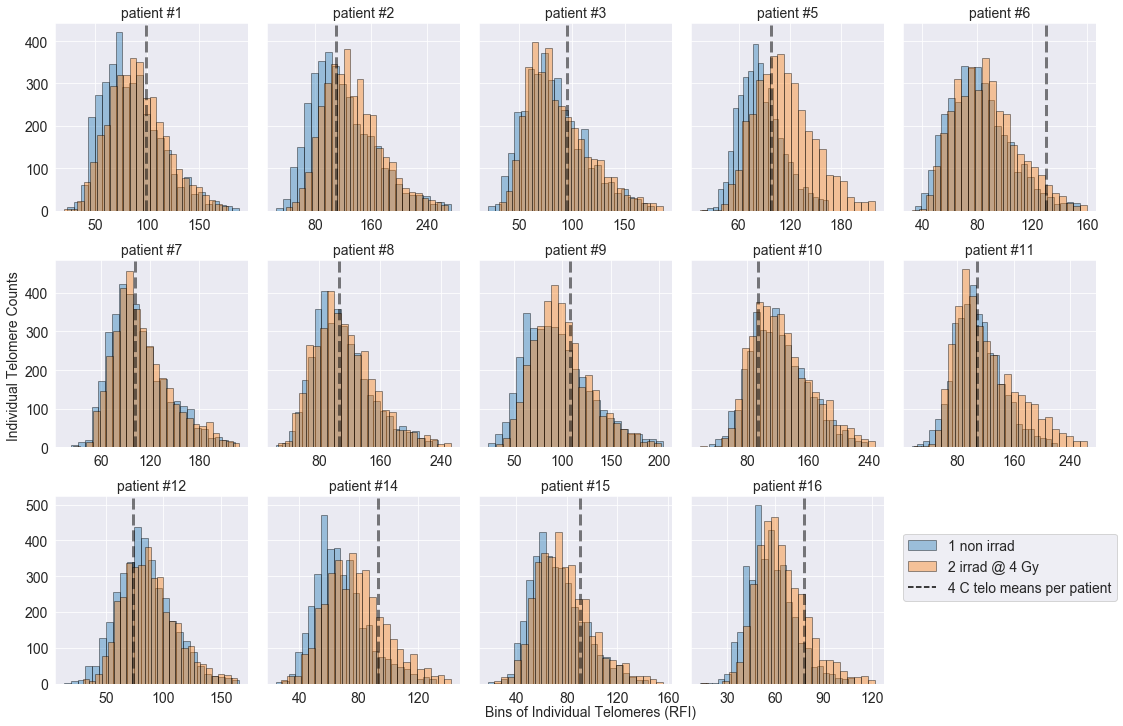

In [172]:
train_viz = train_set.copy()
train_viz.sort_values(by=['patient id'], axis=0, ascending=True, inplace=True)
trp.plot_individ_telos_ML_objective(df=train_viz, target='4 C telo means')

## Cross validation; MAE & R2 score 

In [200]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                                    model=model, cv=5)

MAE per CV fold: 
[3.26004164 3.21415625 3.19590634 3.21412744 3.2344252 ] 

MEAN of MAE all folds: 3.223731373443239
STD of MAE all folds: 0.021867529406798276

MAE of predict_y_test & y_test: 3.2520219879729693
R2 between predict_y_test & y_test: 0.8872179072432078


In [180]:
# evaluating model based on N samples in training data
telo_model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean.sample(n), test_set=test_clean,
                                                        target='4 C telo means',
                                                        model=model, cv=5, verbose=False)
    telo_row[0].append(n)
    telo_model_df += (telo_row)

In [181]:
model_metrics_n_train = pd.DataFrame(telo_model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])
model_metrics_n_train['Features'] = model_metrics_n_train['Features'].apply(lambda row: ', '.join(row))

In [182]:
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | per N training samples 100 to 100000.png'
trp.df_to_png(df=model_metrics_n_train, path=path)

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,14.8465,2.4118,12.9360,-0.6641,100
1,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,10.4491,0.8194,9.7026,-0.0945,500
2,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,8.8928,0.3511,7.9218,0.2017,1000
3,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,6.4488,0.1517,6.1254,0.4972,2000
4,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,4.8807,0.2684,4.5587,0.7226,4000
5,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,3.9677,0.1126,3.8561,0.8112,8000
6,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,3.5669,0.0714,3.5909,0.8492,16000
7,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,3.3825,0.0869,3.3769,0.8720,32000
8,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,3.2675,0.0366,3.1976,0.8815,64000
9,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C telo means,3.1916,0.0559,3.1462,0.8889,103040


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Checking predicted values on per patient basis

In [10]:
full_df = trp.fit_model_return_df_predictions(test_set=test_set, fit_model=fit_xgb_model)

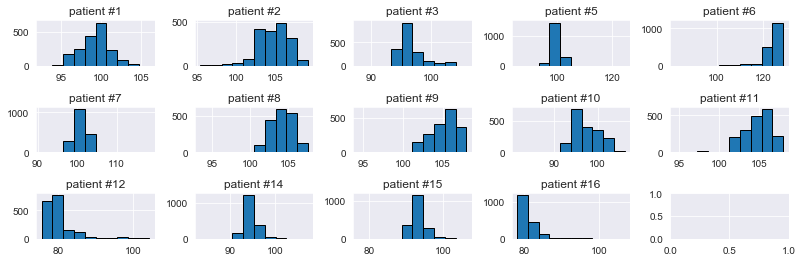

In [11]:
patient_IDs = list(full_df.sort_values(by=['patient id'], ascending=True)['patient id'].unique())

fig, ax = plt.subplots(3, 5, figsize=(11.25,3.75))
axes = ax.ravel()

for axe, patient_ID in zip(axes, patient_IDs):
    df = full_df[full_df['patient id'] == patient_ID].copy()
    df['predictions'].hist(ax=axe)
    axe.set_title(f'patient #{patient_ID}', fontsize=12)
plt.tight_layout()

In [201]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                                                   model=fit_xgb_model, target='4 C telo means',
                                                                   clean_process_pipe=clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C telo means: 3.01532437767921
R2 predicted vs. actual 4 C telo means: 0.9264877840554109


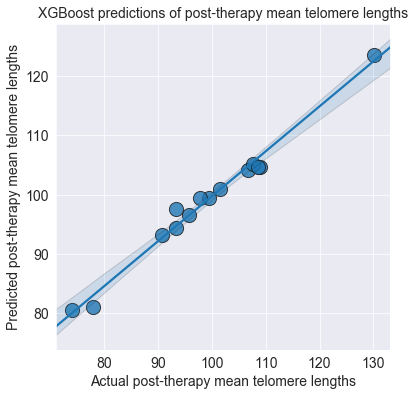

In [155]:
sns.set_color_codes()

plt.figure(figsize=(6,6))

ax = sns.regplot(x=y_true_list, y=y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'},)


ax.set_xlabel("Actual post-therapy mean telomere lengths", fontsize=14)
ax.set_ylabel("Predicted post-therapy mean telomere lengths", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('XGBoost predictions of post-therapy mean telomere lengths', fontsize=14, )
# plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C mean telos vs predicted.png', 
#             dpi=400, bbox_inches = "tight")

## Dataframe for model metrics

In [129]:
stats_df = trp.make_stats_df(stats_list=telo_row)
stats_df

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.1847,0.0244,3.1211,0.8872


In [130]:
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C mean telos | features_individ telos.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Trialing model interpretability functions

In [76]:
shap.initjs()

X = test_clean.drop('4 C telo means', axis=1).sample(5000, random_state=2)

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(fit_xgb_model)
shap_values = explainer.shap_values(X)

# change to jupyter theme light mode for viz
shap.force_plot(explainer.expected_value, shap_values, X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
shap.force_plot is slow for many thousands of rows, try subsampling your data.


## Testing if linear regression can predict 4C mean telos using individual telos

In [ ]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

In [ ]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_lr_model, row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                              model=lr_model, cv=5)

In [ ]:
lr_y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_lr_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe, verbose=False)

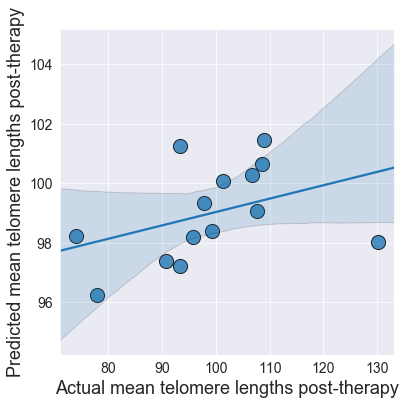

In [26]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true_list, y=lr_y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'},)
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=18)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=18)
ax.tick_params(labelsize=14)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [251]:
exploded_telos_all_patients_df = pd.read_csv('../data/compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')

In [252]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      prediction_objective='4 C # short telos from individual telos')
quartile_telo_data.head()

,patient id,timepoint,individual telomeres,4 C # short telos
0,1,1 non irrad,70.743017,372
1,1,2 irrad @ 4 Gy,91.860335,372
2,1,1 non irrad,91.860335,372
3,1,2 irrad @ 4 Gy,119.311656,372
4,1,1 non irrad,59.128492,372


In [206]:
# saving view of preprocessed data
quartile_telo_head_15 = quartile_telo_data.head(15)
path=f'../graphs/paper figures/supp figs/view of precleaned individual telomere length SHORT TELOS dataframe.png'
trp.df_to_png(df=quartile_telo_head_15, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Train/test split 

In [253]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [254]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [255]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=0, gamma=3)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', q_clean_process_pipe),
                        ('model', q_model)
                       ])

## Cleaning/modeling data with pipeline

In [256]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

In [220]:
q_train_clean.head()

,individual telomeres,4 C # short telos,timepoint_2 irrad @ 4 Gy
0,118.989105,1182.0,1
1,104.163147,124.0,0
2,89.431647,1258.0,1
3,72.252942,829.0,0
4,112.285279,1258.0,0


In [221]:
# saving view of post-processed data
q_train_clean_head_15 = q_train_clean[['timepoint_2 irrad @ 4 Gy', 
                                       'individual telomeres', 
                                       '4 C # short telos']].copy().head(15)

path=f'../graphs/paper figures/supp figs/view of cleaned individual telomere length SHORT TELOS dataframe.png'
trp.df_to_png(df=q_train_clean_head_15, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


## Visualizing model objective

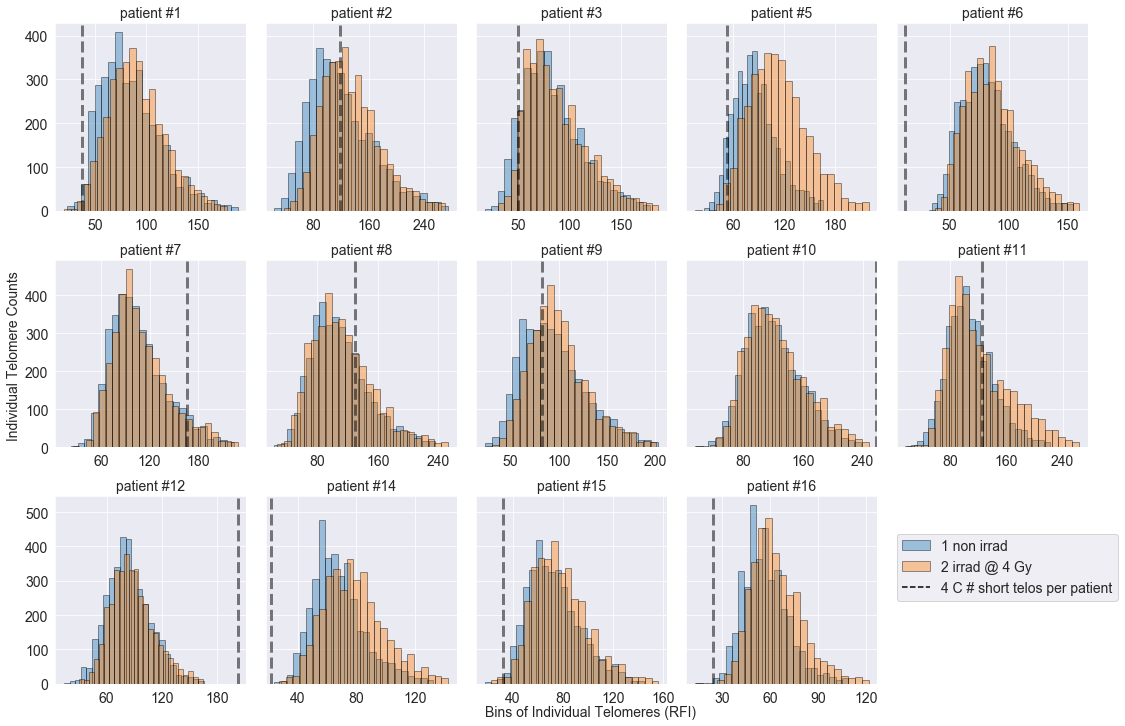

In [257]:
q_train_set.sort_values(by='patient id', ascending=True, inplace=True)
q_train_set.reset_index(drop=True, inplace=True)
temp = q_train_set.copy()
temp['4 C # short telos'] = temp['4 C # short telos'] / 10

trp.plot_individ_telos_ML_objective(df=temp, target='4 C # short telos')

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [ ]:
q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean.sample(n), 
                                                                 test_set=q_test_clean, model=q_model, 
                                                                 cv=5, target='4 C # short telos',
                                                                 verbose=False)

In [259]:
# evaluating model based on N samples in training data
short_telos_model_df = []

for n in [100, 500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 103040]:
    q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean.sample(n), 
                                                                 test_set=q_test_clean, model=q_model, 
                                                                 cv=5, target='4 C # short telos',
                                                                 verbose=False)
    short_telos_row[0].append(n)
    short_telos_model_df += (short_telos_row)

In [260]:
q_model_metrics_n_train = pd.DataFrame(short_telos_model_df, 
                                     columns=['Model', 'Features', 'Target', 'Average MAE of CV folds', 
                                              'Std dev of MAE of CV folds', 'MAE predicted vs. test values', 
                                              'R2 predicted vs. test values', 'N samples training data'])

q_model_metrics_n_train['Features'] = q_model_metrics_n_train['Features'].apply(lambda row: ', '.join(row))

In [261]:
display(q_model_metrics_n_train)
path=f'../graphs/paper figures/supp figs/ML model metrics target_4C number short telos | per N training samples 100 to 100000.png'
trp.df_to_png(df=q_model_metrics_n_train, path=path)

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,634.0483,56.6017,657.3041,-0.4891,100
1,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,543.6848,24.0291,528.2611,-0.0598,500
2,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,482.0856,21.8663,426.8731,0.2698,1000
3,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,362.7817,25.3314,338.0480,0.5215,2000
4,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,302.4140,11.4130,297.6494,0.6466,4000
5,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,263.4891,6.3002,273.5991,0.7095,8000
6,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,252.7579,5.1470,250.8127,0.7713,16000
7,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,249.8871,3.8347,246.7801,0.7826,32000
8,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,236.7991,2.7242,239.3632,0.8002,64000
9,XGBoost,"individual telomeres, timepoint_2 irrad @ 4 Gy",4 C # short telos,237.8903,2.9488,228.3739,0.8215,103040


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [263]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C # short telos: 206.83663940429688
R2 predicted vs. actual 4 C # short telos: 0.8769843858203813


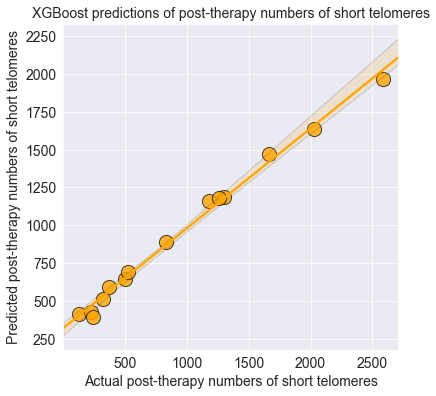

In [157]:
sns.set_color_codes()

plt.figure(figsize=(6,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, color='orange')
ax.set_xlabel("Actual post-therapy numbers of short telomeres", fontsize=14)
ax.set_ylabel("Predicted post-therapy numbers of short telomeres", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_title('XGBoost predictions of post-therapy numbers of short telomeres', fontsize=14, )
plt.savefig(f'../graphs/paper figures/main figs/ML model actual 4 C # short telomeres vs predicted.png', 
            dpi=400, bbox_inches = "tight")

## Dataframe for model metrics

In [274]:
telos_short_telos_rows = telo_row + short_telos_row
stats_df = trp.make_stats_df(stats_list=telos_short_telos_rows)
stats_df

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C telo means,3.1916,0.0559,3.1462,0.8889,103040
1,XGBoost,"[individual telomeres, timepoint_2 irrad @ 4 Gy]",4 C # short telos,237.8903,2.9488,228.3739,0.8215,103040


In [275]:
path=f'../graphs/paper figures/supp figs/ML models predicting #1 4 C telo means and #2 # short telos.png'
trp.df_to_png(df=stats_df, path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


# Machine Learning - exploring predictions of chromosome rearrangements

## Loading data & general cleaning

In [202]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner())])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

## Train/test split 

In [203]:
chr_train, chr_test = train_test_split(cleaned_chr_df, test_size=0.2, shuffle=True, 
                                       stratify=cleaned_chr_df[['patient id', 'timepoint']])

In [183]:
# # testing if adding 1 to every observation/CA enhances ML.. (it doesn't)

# chr_train = chr_train.copy()
# for col in chr_train.columns:
#     if col != 'patient id' and col != 'timepoint':
#         chr_train[col] = chr_train[col] + 1
# #         chr_train[col] = np.log10(chr_train[col])
        
# chr_test = chr_test.copy()
# for col in chr_test.columns:
#     if col != 'patient id' and col != 'timepoint':
#         chr_test[col] = chr_test[col] + 1
# #         chr_test[col] = np.log10(chr_test[col])

## Initializing cleaning/model pipelines

In [184]:
features = ['# inversions']
target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=True, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))])

In [185]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,)

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

In [186]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

## Cross validation; MAE & R2 score when predicting # of chr aberrations post-therapy (4 C)

In [176]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data; w/ model, predict y_test from X_test; score model by MAE/R2 - return model
chr_fit_xgb_model, row = trp.cv_score_fit_mae_test(train_set=cleaned_chr_train, test_set=cleaned_chr_test,
                                              model=chr_model, cv=5, target='4 C # inversions')

MAE per CV fold: 
[0.26435362 0.11783334 0.16328495 0.1956947  0.19447457] 

MEAN of MAE all folds: 0.1871282368001082
STD of MAE all folds: 0.0478777565807688

MAE of predict_y_test & y_test: 0.3429797590961532
R2 between predict_y_test & y_test: -0.1308759501893253


In [155]:
chr_y_predict, y_true, = trp.chr_aberr_predict_target_4C_compare_actual(cleaned_unsplit_chr_data=cleaned_chr_df, 
                                                                        cleaned_test_set=cleaned_chr_test, 
                                                                        model=chr_fit_xgb_model, target='4 C # inversions',
                                                                        clean_process_pipe=make_new_features_target, verbose=False)

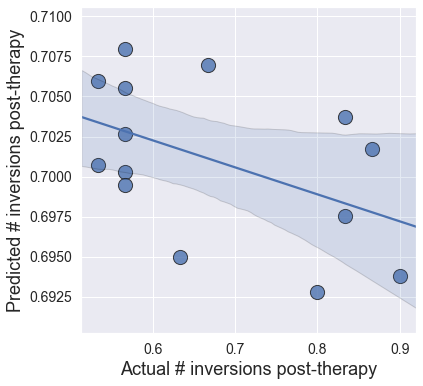

In [156]:
plt.figure(figsize=(6,6))
ax = sns.regplot(x=y_true, y=chr_y_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # inversions post-therapy', fontsize=18)
ax.set_ylabel('Predicted # inversions post-therapy', fontsize=18)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 2', weight='bold', fontsize=20)

## Looping through all chr aberration types for XGBoost model fitting, creating dict for graphing & list for displaying model metrics

In [187]:
features_list = [['# inversions'], ['# translocations'], 
                 ['# dicentrics'], ['# excess chr fragments'],
                 ['# inversions', '# translocations', '# dicentrics', '# excess chr fragments']]

           
target1_list = ['# inversions', '# translocations', 
                '# dicentrics', '# excess chr fragments',
                'aberration index']

target2_list = ['4 C # inversions', '4 C # translocations', 
                '4 C # dicentrics', '4 C # excess chr fragments',
                '4 C aberration index']

stats_list = []
stats_list, graphing_dict = trp.script_load_clean_data_ml_pipeline_loop_aberrations(features_list=features_list,
                                                                                    target1_list=target1_list,
                                                                                    target2_list=target2_list,
                                                                                    stats_list=stats_list,
                                                                                    verbose=False)

## Displaying model metrics in dataframe & graphing performance

In [188]:
import copy

stats_list_copy = copy.deepcopy(stats_list)
n_rows = cleaned_chr_train.shape[0]

for row in stats_list_copy:
    row.append(n_rows)

In [190]:
840-672

168

In [189]:
# saving df of model metrics for chr aberr models

graphing_df = trp.make_graphing_df(graphing_dict=graphing_dict)
stats_df = trp.make_stats_df(stats_list=stats_list_copy)
stats_df['Features'] = stats_df['Features'].apply(lambda row: ', '.join(row))
display(stats_df)

path=f'../graphs/paper figures/supp figs/ML models metrics for all chr aberration types.png'
trp.df_to_png(df=stats_df, path=path)

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. test values,R2 predicted vs. test values,N samples training data
0,XGBoost,"# inversions, timepoint_2 irrad @ 4 Gy",4 C # inversions,0.1279,0.0262,0.3242,-0.0353,672
1,XGBoost,"# translocations, timepoint_2 irrad @ 4 Gy",4 C # translocations,0.0471,0.0175,0.1211,-0.1665,672
2,XGBoost,"# dicentrics, timepoint_2 irrad @ 4 Gy",4 C # dicentrics,0.1122,0.0368,0.2590,-0.2797,672
3,XGBoost,"# excess chr fragments, timepoint_2 irrad @ 4 Gy",4 C # excess chr fragments,0.0826,0.0310,0.1830,-0.5489,672
4,XGBoost,"# inversions, # translocations, # dicentrics, ...",4 C aberration index,0.2460,0.0586,0.4969,-0.0892,672


Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [123]:
# saving df of model metrics for all models
all_rows = telo_row + short_telos_row + stats_list_copy
stats_df = trp.make_stats_df(stats_list=all_rows)

path=f'../graphs/paper figures/supp figs/ML model metrics for all telo and chr aberr endpoints.png'
trp.df_to_png(df=stats_df, path=path)

NameError: name 'telo_row' is not defined

In [161]:
graphing_df.rename({'predicted values':'Predicted values',
                    'actual values':'Actual values'}, axis=1, inplace=True)

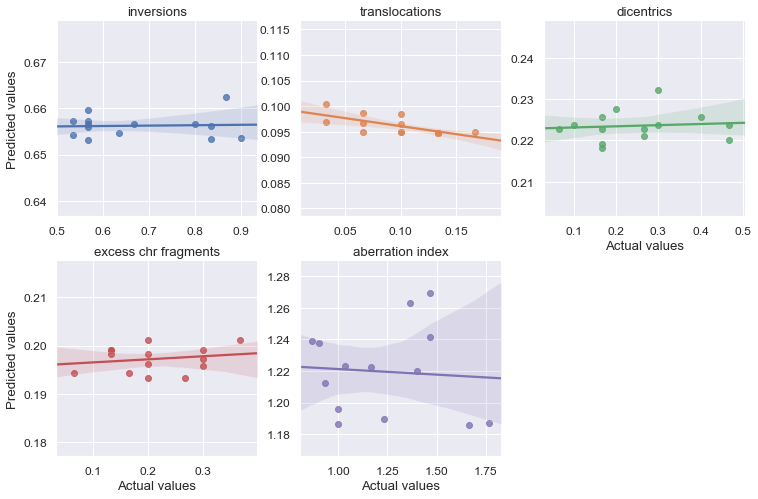

In [163]:
ax = sns.set(font_scale=1.1)
ax = sns.lmplot(x='Actual values', y='Predicted values', col='aberration type', hue='aberration type',
                col_order=['# inversions', '# translocations', 
                           '# dicentrics', '# excess chr fragments', 'aberration index'],
                sharex=False, sharey=False, col_wrap=3, data=graphing_df, height=3.5)

ax_list = ax.axes
ax_list[0].set_title('inversions')
ax_list[1].set_title('translocations')
ax_list[2].set_title('dicentrics')
ax_list[3].set_title('excess chr fragments')
ax_list[4].set_title('aberration index')

plt.tight_layout(pad=.7)
plt.savefig(f'../graphs/paper figures/supp figs/ML models performance for all chr aberr types.png',
            dpi=400, bbox_iches='tight')

## Making dataframes showing chr aberr data setup

In [140]:
# features = ['# inversions', '# translocations', '# dicentrics', '# excess chr fragments']
# target = 'aberration index'

features = ['# inversions']
target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=True, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))])

In [141]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,)

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

## Cleaning/modeling data with pipeline

In [142]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

In [139]:
# aberration index

test_viz_post = cleaned_chr_train[['patient id', 'timepoint_2 irrad @ 4 Gy', '# inversions', '# translocations', 
                                   '# dicentrics', '# excess chr fragments', '4 C aberration index']]

test_viz_pre = chr_train[['patient id', 'timepoint', '# inversions', '# translocations', 
                          '# dicentrics', '# excess chr fragments',]]

test_viz_PRE = (test_viz_pre[test_viz_pre['timepoint'].isin(['1 non irrad', '2 irrad @ 4 Gy'])]
                .merge(cleaned_chr_train[['patient id', '4 C aberration index']])
                .sort_values(by=['patient id', 'timepoint'])
                .reset_index(drop=True))

path=f'../graphs/paper figures/supp figs/example view ALL chr aberr PRE CLEAN dataframe for ML.png'
trp.df_to_png(df=test_viz_PRE.sample(7).reset_index(drop=True), path=path)
path=f'../graphs/paper figures/supp figs/example view ALL chr aberr POST CLEAN dataframe for ML.png'
trp.df_to_png(df=test_viz_post.sample(7).reset_index(drop=True), path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


In [143]:
# inversions

test_viz_post = cleaned_chr_train[['patient id', 'timepoint_2 irrad @ 4 Gy', '# inversions', 
                                   '4 C # inversions']]

test_viz_pre = chr_train[['patient id', 'timepoint', '# inversions']]

test_viz_PRE = (test_viz_pre[test_viz_pre['timepoint'].isin(['1 non irrad', '2 irrad @ 4 Gy'])]
                .merge(cleaned_chr_train[['patient id', '4 C # inversions']])
                .sort_values(by=['patient id', 'timepoint'])
                .reset_index(drop=True))

path=f'../graphs/paper figures/supp figs/example view INVERSIONS PRE CLEAN chr aberr dataframe for ML.png'
trp.df_to_png(df=test_viz_PRE.sample(7).reset_index(drop=True), path=path)
path=f'../graphs/paper figures/supp figs/example view INVERSIONS POST CLEAN chr aberr dataframe for ML.png'
trp.df_to_png(df=test_viz_post.sample(7).reset_index(drop=True), path=path)

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


# Clustering telomere data

## Mean telomere length (teloFISH)

In [601]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
means = all_patients_df.drop(['telo data', 'Q1', 'Q2-3', 'Q4'], axis=1)

In [83]:
pivot = means.pivot_table(index=['patient id'], columns='timepoint', values='telo means').reset_index()
pivot.columns.name = ''

pivot = pivot[pivot['patient id'] != 13].copy()
pivot.set_index(pivot['patient id'], inplace=True)
pivot.drop(['patient id'], axis=1, inplace=True)

In [ ]:
def graph_clustermap(df=None, cluster_target=None
                     cbar_label=None, heatmap_label=None,
                     method='single', metric'correlation', 
                     cmap='PRGn', figsize=(7,7),
                     z_score=0, col_cluster=False)

g = sns.clustermap(pivot, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Mean Telomere Length', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

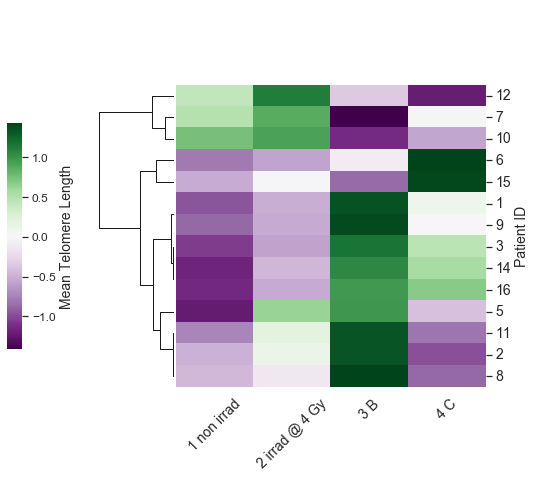

In [524]:
g = sns.clustermap(pivot, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Mean Telomere Length', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by mean telomere length means teloFISH.png', 
            dpi=400, bbox_inches = "tight")

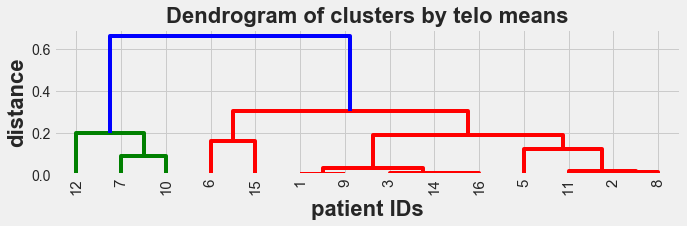

0 Cluster number 2 has 11 elements
1 Cluster number 1 has 3 elements


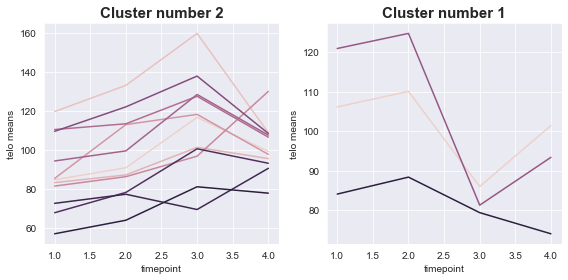

In [85]:
clustered_telos = trp.cluster_data_return_df(means, target='telo means', cut_off_n=2,
                                             metric='correlation', method='single',
                                             x_size=8, y_size=4)

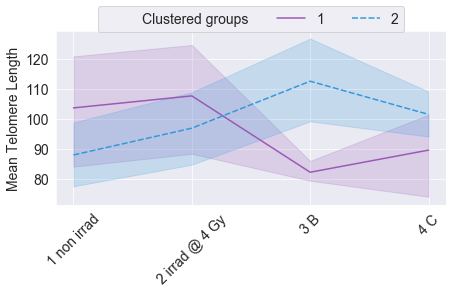

In [86]:
clustered_graphing = clustered_telos.rename({'telo means cluster groups': 'Clustered groups'}, axis=1).copy()

trp.graph_cluster_groups(clustered_graphing, target='telo means', hue='Clustered groups')

In [234]:
clustered_graphing.head()

,patient id,Clustered groups,timepoint,telo means
0,1,2,1 non irrad,84.796483
1,2,2,1 non irrad,119.773675
2,3,2,1 non irrad,83.350928
3,5,2,1 non irrad,85.506106
4,6,2,1 non irrad,81.577970


In [235]:
df = clustered_graphing[clustered_graphing['Clustered groups'] == 1] 

trp.telos_scipy_anova_post_hoc_tests(df0=df, time_col='timepoint', target='telo means',
                                     sig_test=stats.f_oneway, post_hoc='tukeyHSD', repeated_measures=True)

REPEATED MEASURES ANOVA for telomere length: 0.04395417105675324
      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
    group1         group2     meandiff  lower    upper  reject
--------------------------------------------------------------
 1 non irrad   2 irrad @ 4 Gy  4.0158  -34.9883 43.0199 False 
 1 non irrad        3 B       -21.5157 -60.5198 17.4884 False 
 1 non irrad        4 C       -14.1147 -53.1189 24.8894 False 
2 irrad @ 4 Gy      3 B       -25.5315 -64.5356 13.4726 False 
2 irrad @ 4 Gy      4 C       -18.1306 -57.1347 20.8736 False 
     3 B            4 C        7.401   -31.6032 46.4051 False 
--------------------------------------------------------------


telo means CLUSTER 1 | patient IDs: [7, 10, 12]
telo means CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


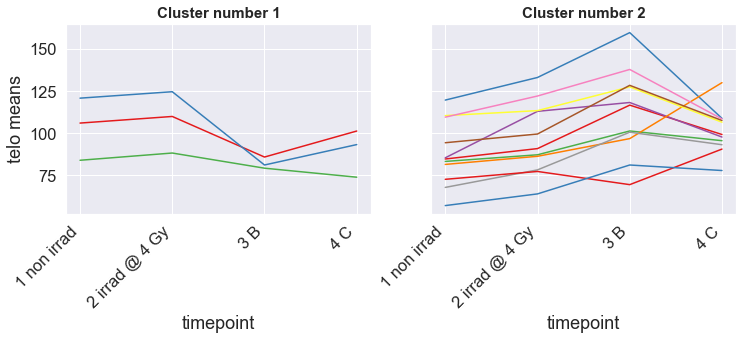

In [25]:
trp.graph_clusters_per_patient(clustered_telos, target='telo means',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

## Short telomeres

In [605]:
all_patients_df = pd.read_csv('../data/compiled patient data csv files/all_patients_df.csv')
short_telos = all_patients_df.drop(['telo data', 'Q2-3', 'Q4', 'telo means'], axis=1)
short_telos.rename(columns={'Q1': 'Number of short telomeres'}, inplace=True)

In [529]:
pivot1 = short_telos.pivot_table(index=['patient id'], columns='timepoint', values='Number of short telomeres').reset_index()
pivot1.columns.name = ''

pivot1 = pivot1[pivot1['patient id'] != 13].copy()
pivot1.set_index(pivot1['patient id'], inplace=True)
pivot1.drop(['patient id'], axis=1, inplace=True)

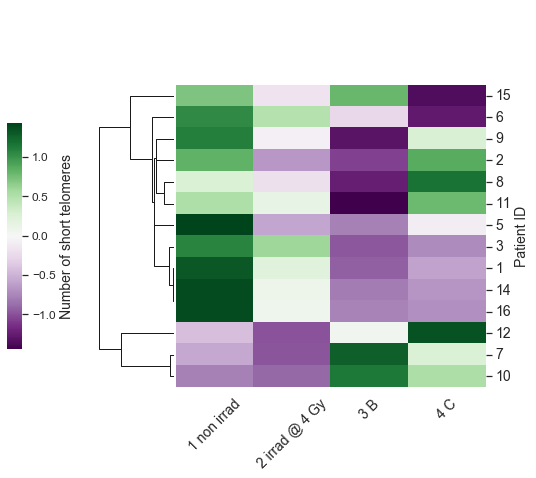

In [530]:
g = sns.clustermap(pivot1, method='single', metric='correlation',
                   z_score=0, figsize=(7,7), cmap='PRGn',
#                    standard_scale=0, 
                   col_cluster=False,
                   cbar_kws={},) 
font_size=14

# colorbar 
g.cax.set_position([-0.05, .2, .03, .45])
g.cax.set_ylabel('Number of short telomeres', rotation=90, fontsize=font_size)
g.cax.tick_params(labelsize=12)

# modifying y axis
g.ax_heatmap.set_ylabel('Patient ID', fontsize=font_size)
labels = g.ax_heatmap.yaxis.get_majorticklabels()
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), fontsize=font_size)
plt.setp(g.ax_heatmap.yaxis.get_minorticklabels(), fontsize=font_size)
g.ax_heatmap.set_yticklabels(labels, rotation=0, fontsize=font_size, va="center")

# modifying x axis
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, fontsize=font_size)

for a in g.ax_row_dendrogram.collections:
    a.set_linewidth(1)
for a in g.ax_col_dendrogram.collections:
    a.set_linewidth(1)

plt.savefig('../graphs/paper figures/main figs/CLUSTERING heatmap all patient by short telomeres teloFISH.png', 
            dpi=400, bbox_inches = "tight")

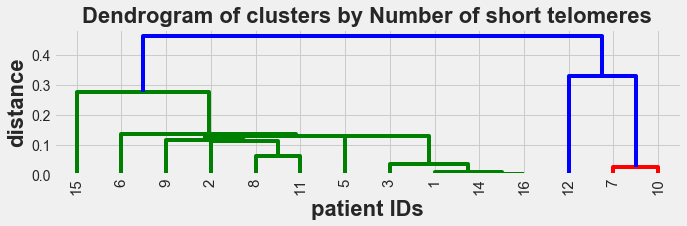

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


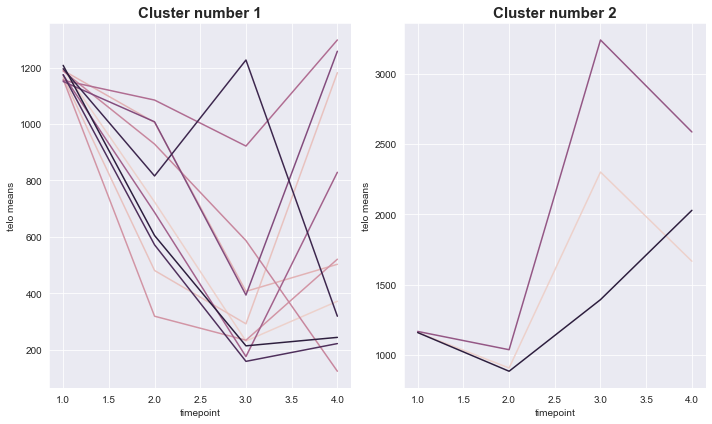

In [91]:
clustered_short_telos = trp.cluster_data_return_df(short_telos, target='Number of short telomeres', cut_off_n=2)

In [92]:
clustered_short_telos['Clustered groups'] = (clustered_short_telos['Number of short telomeres cluster groups']
                                                             .apply(lambda row: trp.swap_short_telos_group_number(row)))

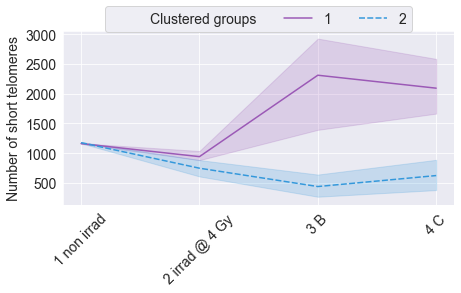

In [93]:
trp.graph_cluster_groups(clustered_short_telos, target='Number of short telomeres', hue='Clustered groups')

# short telomeres CLUSTER 1 | patient IDs: [7, 10, 12]
# short telomeres CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


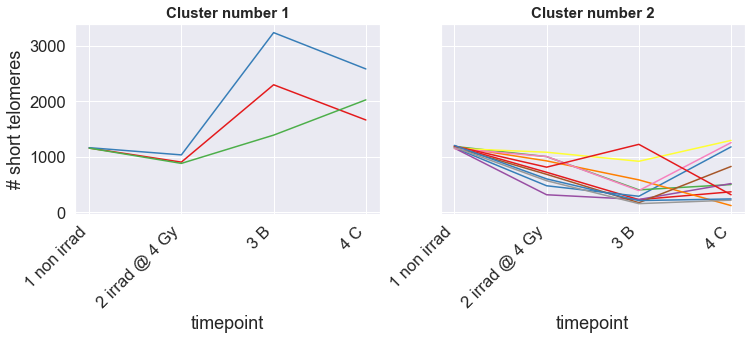

In [31]:
trp.graph_clusters_per_patient(clustered_short_telos, target='# short telomeres',
                               y_dimen=1, x_dimen=2, fsize=(12, 3.5))

Clustering analysis by hierarchical clustering of longitudinal changes in mean telomere length and number of short telomeres in the patients yielded 4 groups in each case, distinguishable by differential responses to radiation therapy. When patients were clustered by mean telomere length or number of short telomeres, the clustered groups differed by only one patient, suggesting strong agreement between mean telomere length and number of short telomeres for data clustering. 

## Combining cluster groups of means + short telos

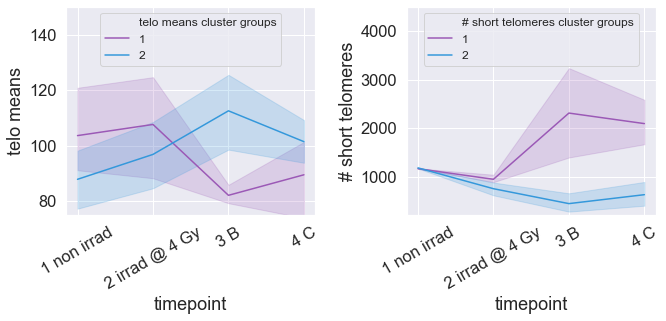

In [33]:
y_list = ['telo means', '# short telomeres']
hue_list = ['telo means cluster groups', '# short telomeres cluster groups']
df_list = [clustered_telos, clustered_short_telos]
ylim_dict = {'telo means': (75, 150),
             '# short telomeres': (200, 4500)}

trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)

## Mean telomere length (qPCR)

In [64]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')
means_qPCR = all_qPCR_df.drop(['SEM'], axis=1)
means_qPCR['timepoint'] = means_qPCR['timepoint'].apply(lambda row: trp.encode_timepts(row))
means_qPCR.head()

,patient id,timepoint,telo means qPCR
0,1,1,2.182028
1,1,3,1.964348
2,1,4,1.749799
3,2,1,1.669445
4,2,3,1.780092


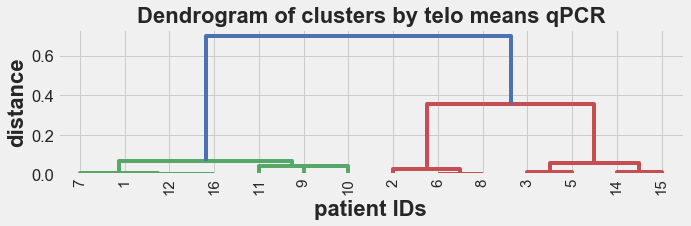

0 Cluster number 1 has 7 elements
1 Cluster number 2 has 7 elements


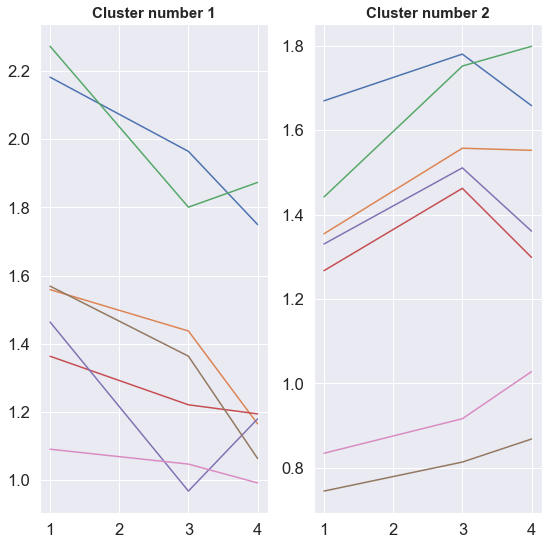

In [65]:
clustered_qPCR = trp.cluster_data_return_df(means_qPCR, target='telo means qPCR', cut_off_n=2,
                                            y_size=9, x_size=9)

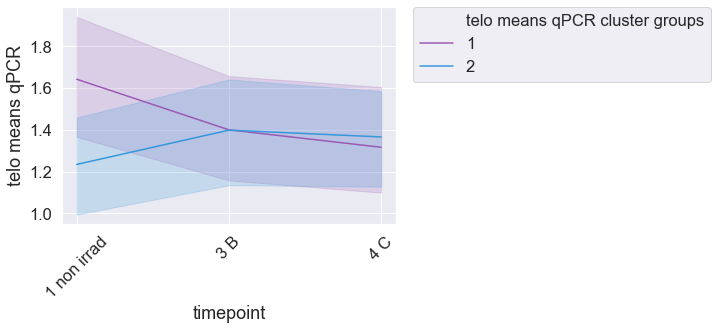

In [66]:
trp.graph_cluster_groups(clustered_qPCR, target='telo means qPCR', hue='telo means qPCR cluster groups')

# Clustering chromosome rearrangement data

In [36]:
all_chr_aberr_df = pd.read_csv('../data/compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False)),
                            ('features', trp.make_chr_features(combine_inversions=True))
                           ])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

In [37]:
mean_chr.head()

,patient id,timepoint,# inversions,# sister chromatid exchanges,# dicentrics,# excess chr fragments,# sat associations,# terminal SCEs,# translocations
0,1,1 non irrad,0.233333,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333
1,1,2 irrad @ 4 Gy,0.766667,0.800000,0.400000,0.366667,0.033333,0.666667,0.133333
2,1,3 B,1.266667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000
3,1,4 C,0.566667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333
4,2,1 non irrad,0.300000,0.533333,0.000000,0.033333,0.333333,0.766667,0.033333


## Testing cluster functions on inversions / excess chr fragments

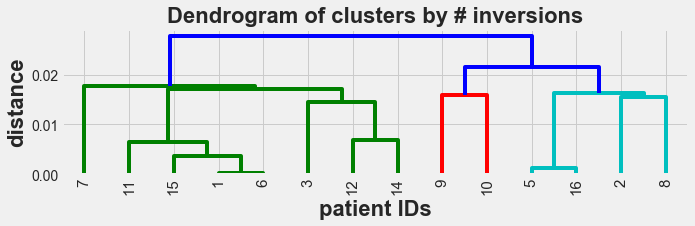

0 Cluster number 1 has 8 elements
1 Cluster number 2 has 6 elements


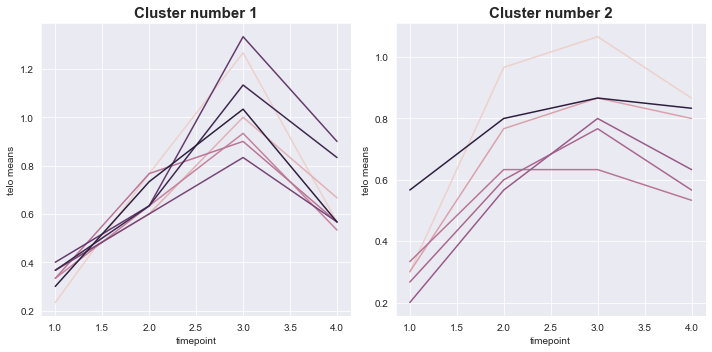

In [38]:
clustered_invs = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2,
                                            y_size=5, x_size=10)

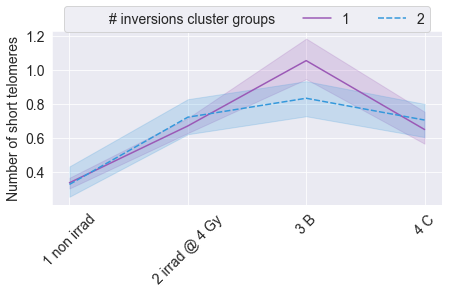

In [39]:
trp.graph_cluster_groups(clustered_invs, target='# inversions', hue='# inversions cluster groups')

# inversions CLUSTER 1 | patient IDs: [1, 3, 6, 7, 11, 12, 14, 15]
# inversions CLUSTER 2 | patient IDs: [2, 5, 8, 9, 10, 16]


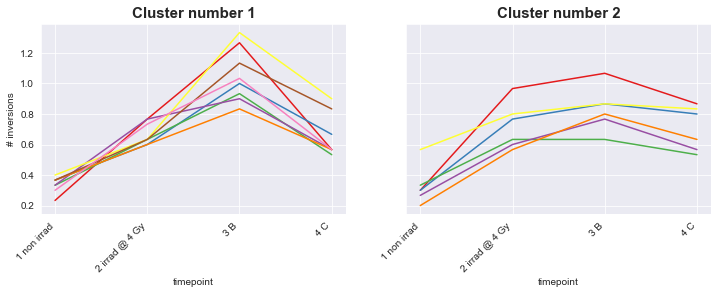

In [40]:
trp.graph_clusters_per_patient(clustered_invs, target='# inversions', y_dimen=1, x_dimen=2, fsize=(12,3.5))

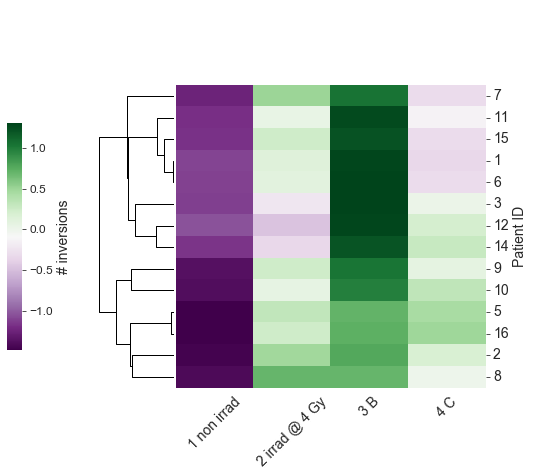

In [41]:
trp.make_clustered_heatmap(df=mean_chr, target='# inversions', cb_target_label='# inversions')

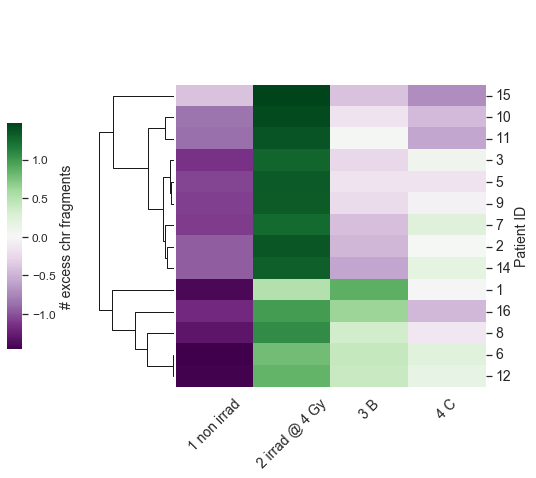

In [609]:
trp.make_clustered_heatmap(df=mean_chr, target='# excess chr fragments', cb_target_label='# excess chr fragments')

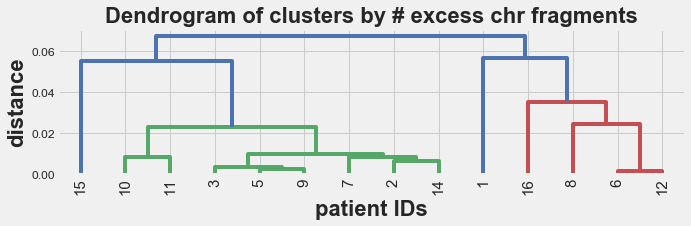

0 Cluster number 2 has 5 elements
1 Cluster number 1 has 9 elements
# excess chr fragments CLUSTER 1 | patient IDs: [2, 3, 5, 7, 9, 10, 11, 14, 15]
# excess chr fragments CLUSTER 2 | patient IDs: [1, 6, 8, 12, 16]


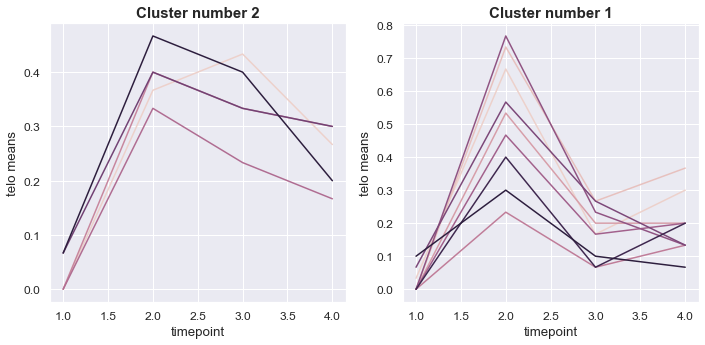

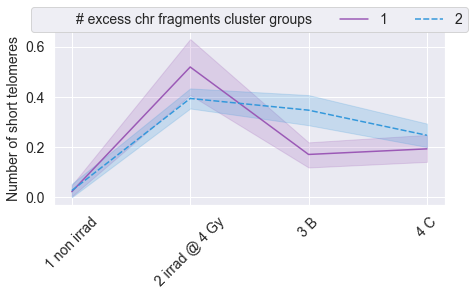

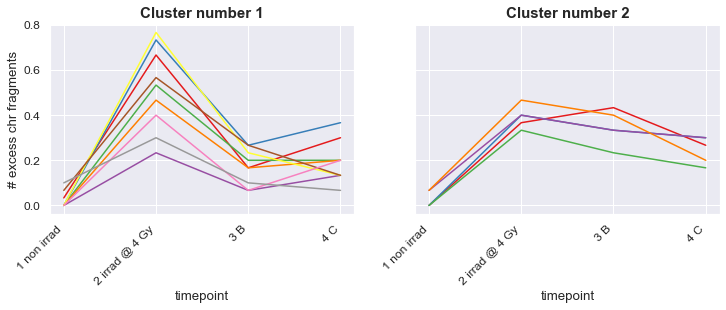

In [508]:
target = '# excess chr fragments'

clustered_invs = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=2, y_size=5, x_size=10)
trp.graph_cluster_groups(clustered_invs, target=target, hue=f'{target} cluster groups')
trp.graph_clusters_per_patient(clustered_invs, target=target, y_dimen=1, x_dimen=2, fsize=(12,3.5))

## Looping through all clustered groups graphs

In [71]:
# chr_aberr = ['# inversions', '# terminal inversions', '# translocations', '# dicentrics']

# for target in chr_aberr:
#     if target == '# inversions':
#         n = 2
#     else:
#         n = 1
#     clustered = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=n)
#     trp.graph_cluster_groups(clustered, target=target, hue=f'{target} cluster groups')
#     trp.graph_clusters_per_patient(clustered, target=target, y_dimen=1, x_dimen=2, fsize=(12,3.5))

## Graphing all aberration cluster groups at once

In [42]:
mean_chr['aberration index'] = (mean_chr['# inversions'] + mean_chr['# translocations'] + 
                                mean_chr['# dicentrics'] + mean_chr['# excess chr fragments'])

In [43]:
mean_chr.head()

,patient id,timepoint,# inversions,# sister chromatid exchanges,# dicentrics,# excess chr fragments,# sat associations,# terminal SCEs,# translocations,aberration index
0,1,1 non irrad,0.233333,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333,0.266667
1,1,2 irrad @ 4 Gy,0.766667,0.800000,0.400000,0.366667,0.033333,0.666667,0.133333,1.666667
2,1,3 B,1.266667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000,2.166667
3,1,4 C,0.566667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333,1.033333
4,2,1 non irrad,0.300000,0.533333,0.000000,0.033333,0.333333,0.766667,0.033333,0.366667


In [54]:
# initializing list of aberrations to cluster by
y_list = ['# inversions', 
          '# translocations', 
          '# dicentrics',
          '# excess chr fragments',
          'aberration index']

# initializing list of dfs bearing clustered groups
inv_df = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2, verbose=False)
trans_df = trp.cluster_data_return_df(mean_chr, target='# translocations', cut_off_n=1, verbose=False)
dicent_df = trp.cluster_data_return_df(mean_chr, target='# dicentrics', cut_off_n=1, verbose=False)
chr_frag_df = trp.cluster_data_return_df(mean_chr, target='# excess chr fragments', cut_off_n=2, verbose=False)
aberr_index_df = trp.cluster_data_return_df(mean_chr, target='aberration index', cut_off_n=1, verbose=False)

df_list = [inv_df,
           trans_df, 
           dicent_df,
           chr_frag_df,
           aberr_index_df]

# hues to graph by
hue_list = ['# inversions cluster groups',
            '# translocations cluster groups', 
            '# dicentrics cluster groups',
            '# excess chr fragments cluster groups',
            'aberration index cluster groups']

# dimensions for each aberration
ylim_dict = {'# inversions': (.1, 1.7),
             '# translocations': (0, .4),
             '# dicentrics': (0, 1),
             '# excess chr fragments': (0, .95),
             'aberration index': (.2, 3)}

In [57]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


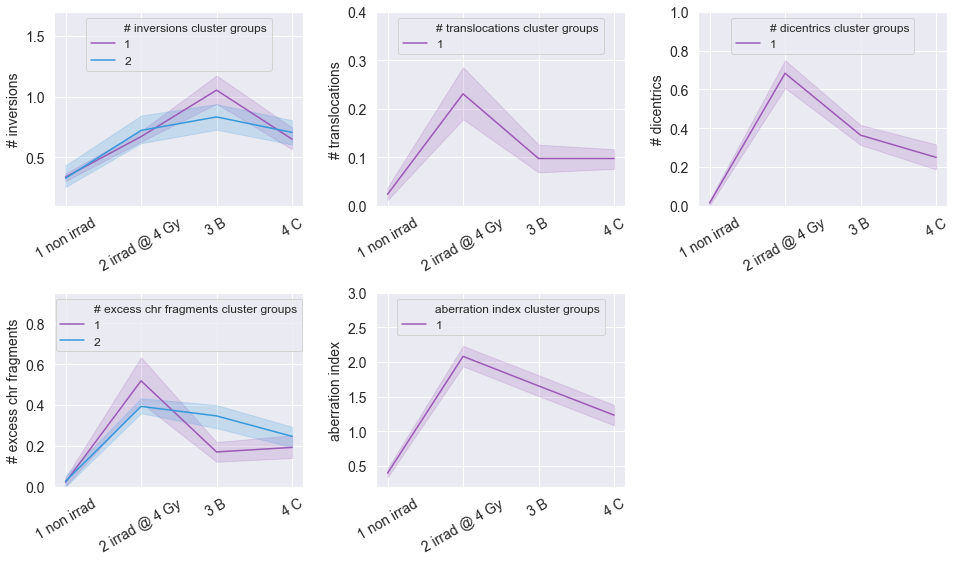

In [58]:
trp.plot_multiple_types_clusters(y_list=y_list, hue_list=hue_list,
                                 df_list=df_list, ylim_dict=ylim_dict)

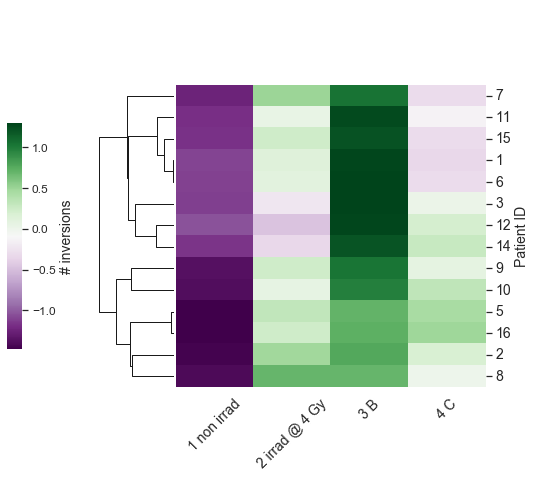

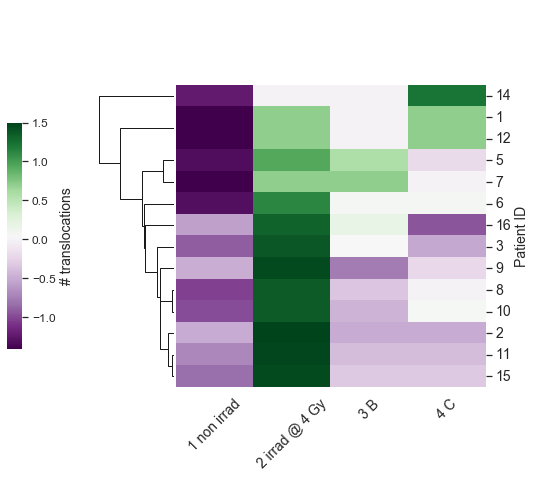

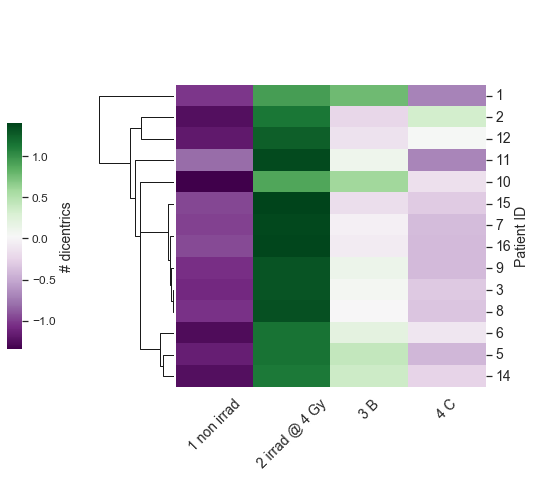

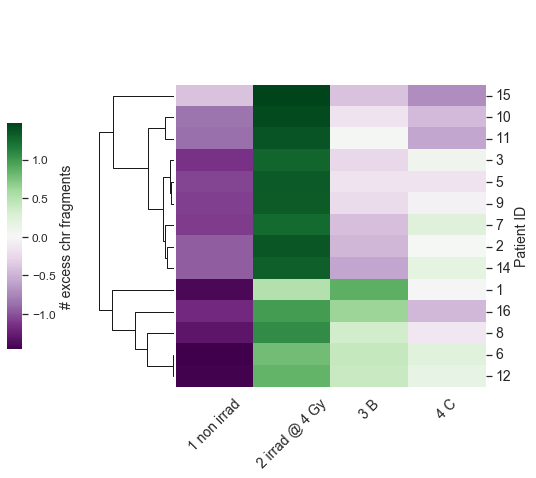

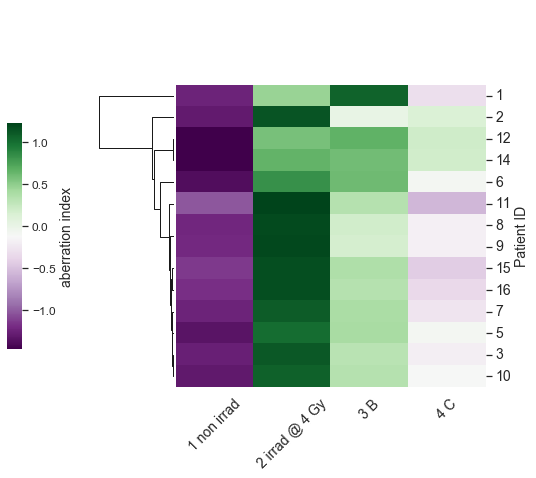

In [59]:
aberr_list = ['# inversions', '# translocations', 
              '# dicentrics', '# excess chr fragments', 'aberration index']

for aberr in aberr_list:
    trp.make_clustered_heatmap(df=mean_chr, target=aberr, cb_target_label=aberr)